In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#Randomized SVD by Halko, et. al.

def rSVD(A, k, p=5):
    """
    Randomized SVD (rSVD) algorithm

    Parameters:
    A (numpy array): matrix to be approximated
    k (int): desired rank of the approximation
    p (int, optional): oversampling parameter (default=5)

    Returns:
    U (numpy array): left singular vectors
    Σ (numpy array): singular values
    V (numpy array): right singular vectors
    """
    m, n = A.shape

    # Generate random matrix Omega
    Omega = np.random.randn(n, k + p)

    # Compute matrix product Y = A * Omega
    Y = np.dot(A, Omega)

    # Compute QR decomposition of Y
    Q, R = np.linalg.qr(Y)

    # Compute B = Q^T * A
    B = np.dot(Q.T, A)

    # Compute SVD of B
    U_B, Sigma_B, V_B = np.linalg.svd(B, full_matrices=False)

    # U = Q * U_B
    U = np.dot(Q, U_B)

    return U, Sigma_B, V_B



(547, 15)
(15,)
(15, 846)


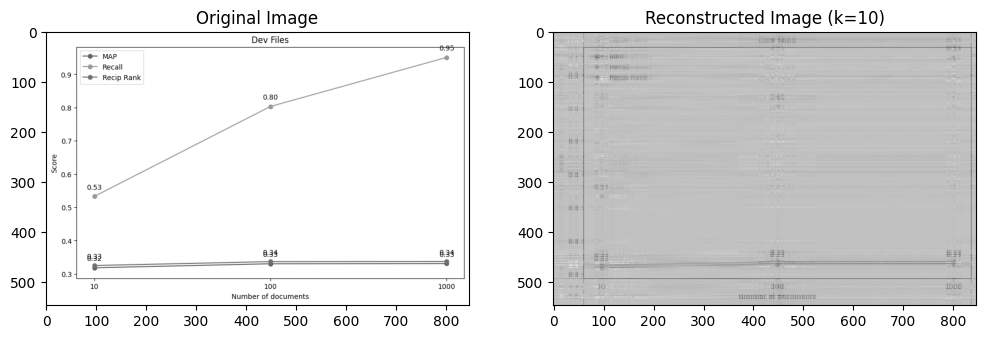

Execution time: 0.6766645908355713 seconds


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import time

start_time = time.time()

# Load the Lena image
img = Image.open('DEV.png')
img = np.array(img)

# Convert the image to grayscale
img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

# Apply the rSVD algorithm
k = 10
U, S, V = rSVD(img_gray, k)

print(U.shape)
print(S.shape)
print(V.shape)

# Reconstruct the image using the top k singular values and vectors
img_reconstructed_rsvd = np.dot(U, np.dot(np.diag(S), V))

# Display the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(img_reconstructed_rsvd, cmap='gray')
plt.title('Reconstructed Image (k=10)')
plt.show()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [ ]:
# Block Krylov SVD

import numpy as np

def block_krylov_SVD(A, k, block_size, num_iterations=5):
    """ Block Krylov method for truncated SVD

    Parameters:
    A (numpy array): matrix to be approximated
    k (int): desired rank of the approximation
    block_size (int): size of the block for Krylov subspace
    num_iterations (int, optional): number of iterations (default=5)

    Returns:
    U (numpy array): left singular vectors
    Σ (numpy array): singular values
    V (numpy array): right singular vectors
    """
    m, n = A.shape

    # Initialize random matrices
    U = np.random.randn(m, k)
    V = np.random.randn(n, k)

    # Normalize columns of U and V
    U = U / np.linalg.norm(U, axis=0)
    V = V / np.linalg.norm(V, axis=0)

    for _ in range(num_iterations):
        # Compute A * V
        Y = np.dot(A, V)

        # Compute QR decomposition of Y
        Q, R = np.linalg.qr(Y)

        # Update U
        U = Q

        # Compute blocks of V
        for i in range(0, k, block_size):
            V_block = np.dot(A.T, U[:, i:i+block_size])
            Q_block, R_block = np.linalg.qr(V_block)
            V[:, i:i+block_size] = Q_block

    # Compute Σ = U^T * A * V
    Σ = np.diag(np.dot(U.T, np.dot(A, V)))

    return U, Σ, V


def block_krylov_SVD_converged(A, A_k, k, block_size, eps=1e-6, max_iter=1000):
    """ Block Krylov method for approximate SVD until convergence

    Parameters:
    A (numpy array): matrix to be approximated
    A_k (numpy array): real truncated A_k
    k (int): desired rank of the approximation
    block_size (int): size of the block for Krylov subspace
    eps (float, optional): convergence tolerance (default=1e-6)
    max_iter (int, optional): maximum number of iterations (default=1000)

    Returns:
    U (numpy array): left singular vectors
    Σ (numpy array): singular values
    V (numpy array): right singular vectors
    """
    m, n = A.shape

    # Initialize random matrices
    U = np.random.randn(m, k)
    V = np.random.randn(n, k)

    # Normalize columns of U and V
    U = U / np.linalg.norm(U, axis=0)
    V = V / np.linalg.norm(V, axis=0)

    iter_count = 0

    while True:
        for _ in range(1):  # Perform one iteration of Krylov
            # Compute A * V
            Y = np.dot(A, V)

            # Compute QR decomposition of Y
            Q, R = np.linalg.qr(Y)

            # Update U
            U = Q

            # Compute blocks of V
            for i in range(0, k, block_size):
                V_block = np.dot(A.T, U[:, i:i+block_size])
                Q_block, R_block = np.linalg.qr(V_block)
                V[:, i:i+block_size] = Q_block

        # Compute Σ = U^T * A * V
        Σ = np.diag(np.dot(U.T, np.dot(A, V)))

        # Compute A_aprx = U Σ V^T
        A_aprx = np.dot(U, np.dot(np.diag(Σ), V.T))

        # Compute Frobenius norms
        norm_A_Ak = np.linalg.norm(A - A_k)
        #print(norm_A_Ak )
        norm_A_Aaprx = np.linalg.norm(A - A_aprx)
        #print(norm_A_Aaprx  )

        if norm_A_Aaprx <= (1 + eps) * norm_A_Ak:
            #print(f"Converged in {iter_count + 1} iterations")
            break

        iter_count += 1

        if iter_count >= max_iter:
            print("Max iterations reached")
            break

    return U, Σ, V, iter_count



In [ ]:
#Block Power SVD

def power_SVD(A, k, num_iterations=5):
  """ Power algorithm for approximate SVD

  Parameters:
  A (numpy array): matrix to be approximated
  k (int): desired rank of the approximation
  num_iterations (int, optional): number of iterations (default=5)

  Returns:
  U (numpy array): left singular vectors
  Σ (numpy array): singular values
  V (numpy array): right singular vectors
  """
  m, n = A.shape

  # Initialize random matrices
  U = np.random.randn(m, k)
  V = np.random.randn(n, k)

  # Normalize columns of U and V
  U = U / np.linalg.norm(U, axis=0)
  V = V / np.linalg.norm(V, axis=0)

  for _ in range(num_iterations):
      # Compute A * V
      Y = np.dot(A, V)

      # Compute QR decomposition of Y
      Q, R = np.linalg.qr(Y)

      # Update U
      U = Q

      # Compute V = A^T * U
      V = np.dot(A.T, U)

      # Compute QR decomposition of V
      Q, R = np.linalg.qr(V)

      # Update V
      V = Q

  # Compute Σ = U^T * A * V
  Σ = np.diag(np.dot(U.T, np.dot(A, V)))

  return U, Σ, V

(547, 10)
(10,)
(846, 10)


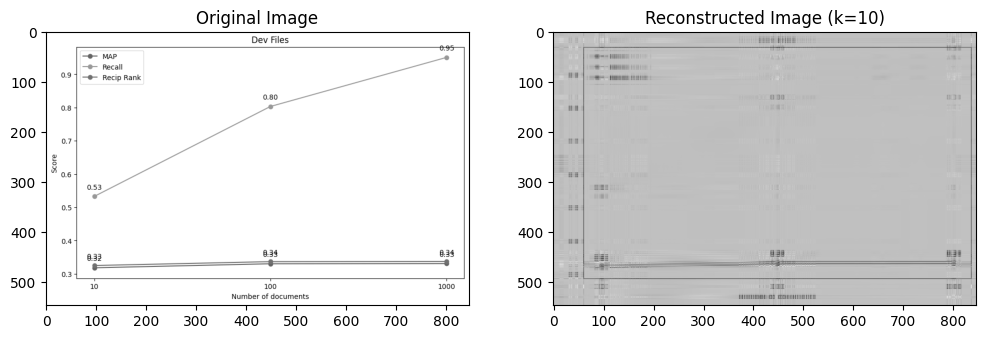

In [ ]:
# Apply the power SVD algorithm
k = 10
U, S, V = power_SVD(img_gray, k)

U_k, S_k, V_k = block_krylov_SVD(img_gray, k, 5)

print(U.shape)
print(S.shape)
print(V.shape)

# Reconstruct the image using the top k singular values and vectors
img_reconstructed = np.dot(U, np.dot(np.diag(S), V.T))

# Display the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(img_reconstructed, cmap='gray')
plt.title('Reconstructed Image (k=10)')
plt.show()

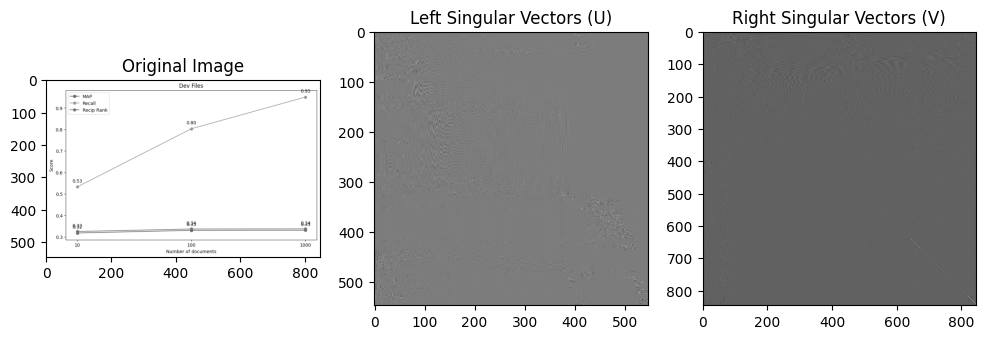

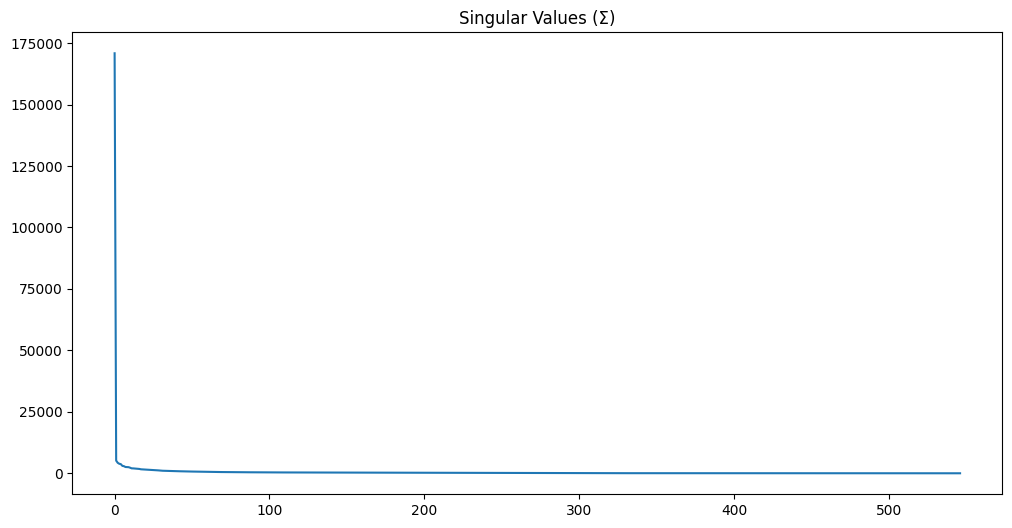

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def full_SVD(A):
    """
    Full SVD decomposition

    Parameters:
    A (numpy array): matrix to be decomposed

    Returns:
    U (numpy array): left singular vectors
    Σ (numpy array): singular values
    V (numpy array): right singular vectors
    """
    U, Σ, V = np.linalg.svd(A, full_matrices=True)
    return U, Σ, V


# Compute full SVD
U, Σ, V = full_SVD(img_gray)

# Display the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Image')

# Display the left singular vectors (U)
plt.subplot(1, 3, 2)
plt.imshow(U, cmap='gray')
plt.title('Left Singular Vectors (U)')

# Display the right singular vectors (V)
plt.subplot(1, 3, 3)
plt.imshow(V, cmap='gray')
plt.title('Right Singular Vectors (V)')
plt.show()

# Display the singular values (Σ)
plt.figure(figsize=(12, 6))
plt.plot(Σ)
plt.title('Singular Values (Σ)')
plt.show()

In [ ]:
import cv2
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

# Compute PSNR
#psnr_1 = peak_signal_noise_ratio(img_gray, img_gray)
#psnr_2 = peak_signal_noise_ratio(img_gray, img_reconstructed)

# Compute MSE
mse1 = mean_squared_error(img_gray, img_gray)
mse2 = mean_squared_error(img_gray, img_reconstructed)
mse3 = mean_squared_error(img_gray, img_reconstructed_rsvd)


# Compute SSIM
#ssim = structural_similarity(img_gray, img_reconstructed)

# Compute VIF
#vif = cv2.calculateVIF(img_gray, img_reconstructed)

#print("PSNR:", psnr_1, psnr_2)
print("MSE:", mse1, mse2, mse3)
#print("SSIM:", ssim)
#print("VIF:", vif)

MSE: 0.0 194.7880012432752 265.50671090944365


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
U_truncated shape: (547, 10)
s_truncated shape: (10,)
Vt_truncated shape: (10, 846)


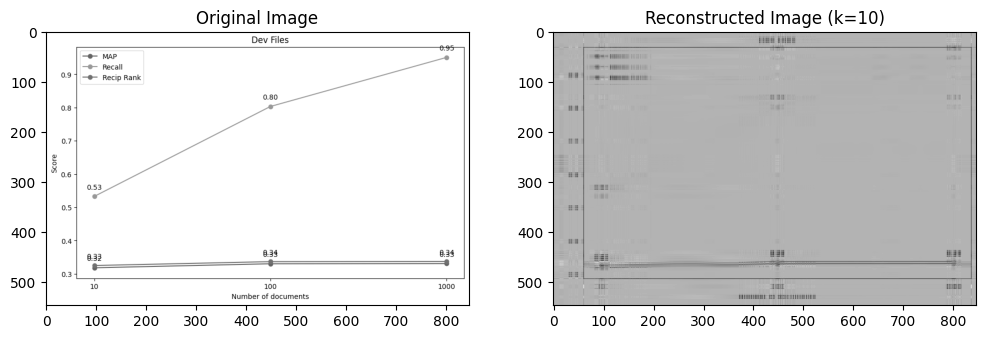

Execution time: 0.7751779556274414 seconds


In [ ]:
%time
import numpy as np

import time

start_time = time.time()

def truncated_svd(matrix, k):
    """
    Perform truncated SVD on a matrix, returning the top k singular values/vectors.

    Parameters:
    - matrix (numpy.ndarray): Input matrix (n x m)
    - k (int): Number of singular values to retain

    Returns:
    - U (numpy.ndarray): Truncated left singular vectors (n x k)
    - s (numpy.ndarray): Truncated singular values (k x k)
    - Vt (numpy.ndarray): Truncated right singular vectors (k x m)
    """
    # Perform full SVD
    U, s, Vt = np.linalg.svd(matrix, full_matrices=False)

    # Get the indices of the top k singular values
    idx = np.argsort(s)[::-1][:k]

    # Truncate the matrices
    U_truncated = U[:, idx]
    s_truncated = s[idx]
    Vt_truncated = Vt[idx, :]

    return U_truncated, s_truncated, Vt_truncated

# Example usage
matrix = np.random.rand(100, 50)  # Create a random 100 x 50 matrix
k = 10  # Retain top 10 singular values

U_truncated, s_truncated, Vt_truncated = truncated_svd(img_gray, k)

print("U_truncated shape:", U_truncated.shape)
print("s_truncated shape:", s_truncated.shape)
print("Vt_truncated shape:", Vt_truncated.shape)


# Reconstruct the image using the top k singular values and vectors
img_reconstructed= np.dot(U_truncated, np.dot(np.diag(s_truncated), Vt_truncated))

# Display the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(img_reconstructed, cmap='gray')
plt.title('Reconstructed Image (k=10)')
plt.show()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [ ]:
def power_iteration(A, num_iter=100):
    # Initialize a random vector
    v = np.random.rand(A.shape[1])

    # Normalize the vector
    v = v / np.linalg.norm(v)

    for _ in range(num_iter):
      # Compute Av
      Av = np.dot(A, v)

      # Compute A^T Av
      A_T_Av = np.dot(A.T, Av)

      # Compute the Rayleigh quotient
      rayleigh_quotient = np.dot(v.T, A_T_Av) / np.dot(v.T, v)

      # Update v
      v = A_T_Av / np.linalg.norm(A_T_Av)

    # Compute the top singular value
    top_singular_value = np.sqrt(rayleigh_quotient)

    # Compute the corresponding singular vector
    top_singular_vector = v

    return top_singular_value, top_singular_vector

def deflation(A, v, sigma):
    # Subtract outer product from A
    A_deflated = A - sigma * np.outer(v, v)  # Use v instead of v.T
    return A_deflated

#Truncated SVD with power deflation
def SVD_power_deflation(matrix, k):
    U = np.zeros((matrix.shape[0], k))
    s = np.zeros((k, k))
    Vt = np.zeros((k, matrix.shape[1]))

    A = matrix.copy()

    for i in range(k):
        sigma, v = power_iteration(A)
        U[:, i] = np.dot(matrix, v) / sigma
        s[i, i] = sigma
        Vt[i, :] = v

        A = deflation(A, v, sigma)

    return U, s, Vt


In [ ]:
import numpy as np

def power_SVD_deflation(A, k, num_iterations=5):
    """ Power algorithm for approximate SVD with deflation

    Parameters:
    A (numpy array): matrix to be approximated
    k (int): desired rank of the approximation
    num_iterations (int, optional): number of iterations (default=5)

    Returns:
    U (numpy array): left singular vectors
    Σ (numpy array): singular values
    V (numpy array): right singular vectors
    """
    m, n = A.shape
    U = np.zeros((m, k))
    Sigma = np.zeros(k)
    V = np.zeros((n, k))

    for i in range(k):
        # Initialize random matrices
        u = np.random.randn(m)
        v = np.random.randn(n)

        for _ in range(num_iterations):
            # Power iteration
            u = np.dot(A, v)
            u /= np.linalg.norm(u)

            v = np.dot(A.T, u)
            v /= np.linalg.norm(v)

        # Store the singular value and vectors
        Sigma[i] = np.dot(u.T, np.dot(A, v))
        U[:, i] = u
        V[:, i] = v

        # Deflate the matrix
        A -= Sigma[i] * np.outer(u, v)

    return U, Sigma, V

In [ ]:
def power_SVD_converged(A, A_k, k, eps=1e-6, max_iter=1000):
  """ Power algorithm for approximate SVD until convergence

  Parameters:
  A (numpy array): matrix to be approximated
  A_k (numpy array): real truncated A_k
  k (int): desired rank of the approximation
  eps (float, optional): convergence tolerance (default=1e-6)
  max_iter (int, optional): maximum number of iterations (default=1000)

  Returns:
  U (numpy array): left singular vectors
  Σ (numpy array): singular values
  V (numpy array): right singular vectors
  """
  m, n = A.shape

  # Initialize random matrices
  U = np.random.randn(m, k)
  V = np.random.randn(n, k)

  # Normalize columns of U and V
  U = U / np.linalg.norm(U, axis=0)
  V = V / np.linalg.norm(V, axis=0)

  iter_count = 0

  while True:
    # Compute A * V
    Y = np.dot(A, V)

    # Compute QR decomposition of Y
    Q, R = np.linalg.qr(Y)

    # Update U
    U = Q

    # Compute V = A^T * U
    V = np.dot(A.T, U)

    # Compute QR decomposition of V
    Q, R = np.linalg.qr(V)

    # Update V
    V = Q

    # Compute Σ = U^T * A * V
    Σ = np.diag(np.dot(U.T, np.dot(A, V)))

    # Compute A_aprx = U Σ V^T
    A_aprx = np.dot(U, np.dot(np.diag(Σ), V.T))

    # Compute Frobenius norms
    norm_A_Ak = np.linalg.norm(A - A_k)
    #print(norm_A_Ak )
    norm_A_Aaprx = np.linalg.norm(A - A_aprx)
    #print(norm_A_Aaprx  )

    if norm_A_Aaprx <= (1 + eps) * norm_A_Ak:
      #print(f"Converged in {iter_count + 1} iterations")
      break

    iter_count += 1

    if iter_count >= max_iter:
      print("Max iterations reached")
      break

  return U, Σ, V, iter_count

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import time

def compute_all(image_path, k, iters_power, iters_krylov):

  # Load the image
  img = Image.open(image_path)
  img = np.array(img)

  # Convert the image to grayscale
  img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

  start_time = time.time()
  # Apply the truncated SVD algorithm
  U, S, V = truncated_svd(img_gray, k)
  end_time = time.time()
  execution_time = end_time - start_time
  #print(f"SVD time:  {execution_time} seconds")
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_svd = np.dot(U, np.dot(np.diag(S), V))
  #real_A_k = img_reconstructed_svd

  start_time = time.time()
  #Apply the rSVD algorithm
  U, S, V = rSVD(img_gray, k)
  end_time = time.time()
  execution_time = end_time - start_time
  #print(f"rSVD time:  {execution_time} seconds")
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_rsvd = np.dot(U, np.dot(np.diag(S), V))

  img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

  start_time = time.time()
  #Apply the power deflation algorithm
  U, S, V = power_SVD_deflation(img_gray, k, iters_krylov)
  end_time = time.time()
  execution_time = end_time - start_time
  print(f"SVD with Power Deflation time:  {execution_time} seconds")
  #Reconstruct the image using the top k singular values and vectors
  img_reconstructed_svd_power_deflation = np.dot(U, np.dot(np.diag(S), V.T))

  img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

  start_time = time.time()
  # Apply the block power SVD
  U, S, V = power_SVD(img_gray, k, iters_power)
  end_time = time.time()
  execution_time_power = end_time - start_time
  print(f"SVD with Block Power Iteration time:  {execution_time} seconds")
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_svd_block_power = np.dot(U, np.dot(np.diag(S), V.T))

  img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

  start_time = time.time()
  # Apply the block Krylov SVD
  U, S, V = block_krylov_SVD(img_gray, k, 1, iters_krylov)
  end_time = time.time()
  execution_time_krylov = end_time - start_time
  print(f"SVD with Krylov Iteration time:  {execution_time} seconds")
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_krylov_svd = np.dot(U, np.dot(np.diag(S), V.T))

  return img_reconstructed_svd_block_power, img_reconstructed_krylov_svd, execution_time_power, execution_time_krylov,

In [ ]:
def compute_all(image_path, k, iters_power, iters_krylov):

  # Load the image
  img = Image.open(image_path)
  img = np.array(img)

  # Convert the image to grayscale
  img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

  start_time = time.time()
  # Apply the truncated SVD algorithm
  U, S, V = truncated_svd(img_gray, k)
  end_time = time.time()
  execution_time_svd = end_time - start_time
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_svd = np.dot(U, np.dot(np.diag(S), V))
  svd_result = (img_reconstructed_svd, execution_time_svd)

  start_time = time.time()
  # Apply the rSVD algorithm
  U, S, V = rSVD(img_gray, k)
  end_time = time.time()
  execution_time_rsvd = end_time - start_time
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_rsvd = np.dot(U, np.dot(np.diag(S), V))
  rsvd_result = (img_reconstructed_rsvd, execution_time_rsvd)

  img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

  start_time = time.time()
  # Apply the power deflation algorithm
  U, S, V = power_SVD_deflation(img_gray, k, iters_krylov)
  end_time = time.time()
  execution_time_power_deflation = end_time - start_time
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_svd_power_deflation = np.dot(U, np.dot(np.diag(S), V.T))
  power_deflation_result = (img_reconstructed_svd_power_deflation, execution_time_power_deflation)

  img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

  start_time = time.time()
  # Apply the block power SVD
  U, S, V = power_SVD(img_gray, k, iters_power)
  end_time = time.time()
  execution_time_power = end_time - start_time
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_svd_block_power = np.dot(U, np.dot(np.diag(S), V.T))
  power_result = (img_reconstructed_svd_block_power, execution_time_power)

  img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

  start_time = time.time()
  # Apply the block Krylov SVD
  U, S, V = block_krylov_SVD(img_gray, k, 1, iters_krylov)
  end_time = time.time()
  execution_time_krylov = end_time - start_time
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_krylov_svd = np.dot(U, np.dot(np.diag(S), V.T))
  krylov_result = (img_reconstructed_krylov_svd, execution_time_krylov)

  return {
    'SVD': svd_result,
    'rSVD': rsvd_result,
    'Power Deflation': power_deflation_result,
    'Block Power SVD': power_result,
    'Block Krylov SVD': krylov_result
  }

In [ ]:
def compute_krylov_and_power(image_path, k, eps=1e-4, max_iter=1000):

  # Load the image
  img = Image.open(image_path)
  img = np.array(img)

  # Convert the image to grayscale
  img_gray = np.dot(img[:, :, :3], [0.2989, 0.5870, 0.1140])

  # Apply the truncated SVD algorithm to get real_A_k
  start_time = time.time()
  U, S, V = truncated_svd(img_gray, k)
  end_time = time.time()
  execution_time_svd = end_time - start_time
  #print(f"SVD time:  {execution_time_svd} seconds")
  real_A_k = np.dot(U, np.dot(np.diag(S), V))

  # Apply the block power SVD
  start_time = time.time()
  U_power, S_power, V_power, iterations_power = power_SVD_converged(img_gray, real_A_k, k, eps=eps, max_iter=max_iter)
  end_time = time.time()
  execution_time_power = end_time - start_time
  #print(f"SVD with Block Power Iteration time:  {execution_time_power} seconds")

  # Apply the block Krylov SVD
  start_time = time.time()
  U_krylov, S_krylov, V_krylov, iterations_krylov = block_krylov_SVD_converged(img_gray, real_A_k, k, 1, eps=eps, max_iter=max_iter)
  end_time = time.time()
  execution_time_krylov = end_time - start_time
  #print(f"SVD with Krylov Iteration time:  {execution_time_krylov} seconds")

  # Reconstruct the images using the top k singular values and vectors
  img_reconstructed_power = np.dot(U_power, np.dot(np.diag(S_power), V_power.T))
  img_reconstructed_krylov = np.dot(U_krylov, np.dot(np.diag(S_krylov), V_krylov.T))

  return img_reconstructed_power, img_reconstructed_krylov, execution_time_power, execution_time_krylov, iterations_power, iterations_krylov


In [ ]:
image1, image2, time1, time2, iters1, iters2 = compute_krylov_and_power("DEV.png", 100)

In [ ]:
U_truncated, s_truncated, Vt_truncated = power_SVD_converged(img_gray, 50)

print("U_truncated shape:", U_truncated.shape)
print("s_truncated shape:", s_truncated.shape)
print("Vt_truncated shape:", Vt_truncated.shape)


# Reconstruct the image using the top k singular values and vectors
img_reconstructed= np.dot(U_truncated, np.dot(np.diag(s_truncated), Vt_truncated.T))

# Display the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(img_reconstructed, cmap='gray')
plt.title('Reconstructed Image (k=10)')
plt.show()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

TypeError: power_SVD_converged() missing 1 required positional argument: 'k'

In [ ]:
import os
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Set the number of images to load
num_images = 100

# Define a transformation to convert images to grayscale
transform = transforms.Compose([transforms.Grayscale(),
                                transforms.ToTensor()])

# Load the Flowers-102 dataset
dataset = datasets.Flowers102('./data', download=True, transform=transform)

# Create a data loader to load the images
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize an empty list to store the images
images = []

# Load the first 100 images
for batch_idx, (data, target) in enumerate(data_loader):
    if batch_idx >= num_images:
        break
    # Convert the image to a numpy array
    image = data.squeeze().numpy()
    # Add the image to the list
    images.append(image)

# Define the Krylov and Power function
def compute_krylov_and_power(image, k, eps=1e-4, max_iter=1000):
    # Your implementation here
    img_gray = image
    # Apply the truncated SVD algorithm to get real_A_k
    start_time = time.time()
    U, S, V = np.linalg.svd(img_gray, full_matrices=False)
    U = U[:, :k]
    S = S[:k]
    V = V[:k, :]
    end_time = time.time()
    execution_time_svd = end_time - start_time
    real_A_k = np.dot(U, np.dot(np.diag(S), V))

    # Apply the block power SVD
    start_time = time.time()
    U_power, S_power, V_power, iterations_power = power_SVD_converged(img_gray, real_A_k, k, eps=eps, max_iter=max_iter)
    end_time = time.time()
    execution_time_power = end_time - start_time

    # Apply the block Krylov SVD
    start_time = time.time()
    U_krylov, S_krylov, V_krylov, iterations_krylov = block_krylov_SVD_converged(img_gray, real_A_k, k, 5, eps=eps, max_iter=max_iter)
    end_time = time.time()
    execution_time_krylov = end_time - start_time

    # Reconstruct the images using the top k singular values and vectors
    img_reconstructed_power = np.dot(U_power, np.dot(np.diag(S_power), V_power.T))
    img_reconstructed_krylov = np.dot(U_krylov, np.dot(np.diag(S_krylov), V_krylov.T))

    return img_reconstructed_power, img_reconstructed_krylov, execution_time_power, execution_time_krylov, iterations_power, iterations_krylov

# Pass each image through the compute_krylov_and_power function
k = 5
eps = 1e-4
max_iter = 1000
results = []
execution_times_power = []
execution_times_krylov = []
iterations_power = []
iterations_krylov = []
for image in images:
    img_reconstructed_power, img_reconstructed_krylov, execution_time_power, execution_time_krylov, iteration_power, iteration_krylov = compute_krylov_and_power(image, k, eps, max_iter)
    results.append((img_reconstructed_power, img_reconstructed_krylov))
    execution_times_power.append(execution_time_power)
    execution_times_krylov.append(execution_time_krylov)
    iterations_power.append(iteration_power)
    iterations_krylov.append(iteration_krylov)

# Print the shape of the first image
print(images[0].shape)

# Print the shape of the first result
print(results[0][0].shape)


KeyboardInterrupt: 

In [ ]:
# Print average execution times and iterations
print("Average execution time for Power SVD: ", np.mean(execution_times_power))
print("Average execution time for Krylov SVD: ", np.mean(execution_times_krylov))
print("Average number of iterations for Power SVD: ", np.mean(iterations_power))
print("Average number of iterations for Krylov SVD: ", np.mean(iterations_krylov))

# Plot the original image, Power SVD reconstructed image, and Krylov SVD reconstructed image
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(images[0], cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(results[0][0], cmap='gray')
axs[1].set_title('Power SVD Reconstructed Image')
axs[2].imshow(results[0][1], cmap='gray')
axs[2].set_title('Krylov SVD Reconstructed Image')
plt.show()

In [ ]:
import numpy as np
import time

# Generate a random matrix of size 1000 by 1200
np.random.seed(0)
A = np.random.rand(10000, 12000)

# Convert the matrix to a numpy array
A = np.array(A)

# Call the compute_krylov_and_power function
start_time = time.time()
k = 10
eps = 1e-4
max_iter = 1000
img_reconstructed_power, img_reconstructed_krylov, execution_time_power, execution_time_krylov, iterations_power, iterations_krylov = compute_krylov_and_power(A, k, eps, max_iter)
end_time = time.time()

# Print the execution time
print("Execution time: ", end_time - start_time)

# Print the execution times for Power SVD and Krylov SVD
print("Execution time for Power SVD: ", execution_time_power)
print("Execution time for Krylov SVD: ", execution_time_krylov)

# Print the number of iterations for Power SVD and Krylov SVD
print("Number of iterations for Power SVD: ", iterations_power)
print("Number of iterations for Krylov SVD: ", iterations_krylov)

In [ ]:
import os
import numpy as np
from PIL import Image
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Set the number of images to load
num_images = 100

# Define a transformation to convert images to grayscale
transform = transforms.Compose([transforms.Grayscale(),
                                transforms.ToTensor()])

# Load the Flowers-102 dataset
dataset = datasets.Flowers102('./data', download=True, transform=transform)

# Create a data loader to load the images
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize an empty list to store the images
images = []

# Load the first 100 images
for batch_idx, (data, target) in enumerate(data_loader):
    if batch_idx >= num_images:
        break
    # Convert the image to a numpy array
    image = data.squeeze().numpy()
    # Add the image to the list
    images.append(image)

# Define the function
def compute_all_2(image, k, iters_power, iters_krylov):

  # Convert the image to grayscale
  img_gray = image.copy()

  start_time = time.time()
  # Apply the truncated SVD algorithm
  U, S, V = np.linalg.svd(img_gray, full_matrices=False)
  U = U[:, :k]
  S = S[:k]
  V = V[:k, :]
  end_time = time.time()
  execution_time_svd = end_time - start_time
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_svd = np.dot(U, np.dot(np.diag(S), V))
  svd_result = (img_reconstructed_svd, execution_time_svd)

  img_gray = image

  start_time = time.time()
  # Apply the rSVD algorithm
  U, S, V = rSVD(img_gray,k,5)
  end_time = time.time()
  execution_time_rsvd = end_time - start_time
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_rsvd = np.dot(U, np.dot(np.diag(S), V))
  rsvd_result = (img_reconstructed_rsvd, execution_time_rsvd)

  img_gray = image

  start_time = time.time()
  # Apply the power deflation algorithm
  U, S, V = power_SVD_deflation(img_gray, k, iters_krylov)
  end_time = time.time()
  execution_time_power_deflation = end_time - start_time
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_svd_power_deflation = np.dot(U, np.dot(np.diag(S), V.T))
  power_deflation_result = (img_reconstructed_svd_power_deflation, execution_time_power_deflation)

  img_gray = image

  start_time = time.time()
  # Apply the block power SVD
  U, S, V = power_SVD(img_gray, k, iters_power)
  end_time = time.time()
  execution_time_power = end_time - start_time
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_svd_block_power = np.dot(U, np.dot(np.diag(S), V.T))
  power_result = (img_reconstructed_svd_block_power, execution_time_power)

  img_gray = image

  start_time = time.time()
  # Apply the block Krylov SVD
  U, S, V = block_krylov_SVD(img_gray, k, 1, iters_krylov)
  end_time = time.time()
  execution_time_krylov = end_time - start_time
  # Reconstruct the image using the top k singular values and vectors
  img_reconstructed_krylov_svd = np.dot(U, np.dot(np.diag(S), V.T))
  krylov_result = (img_reconstructed_krylov_svd, execution_time_krylov)

  return {
    'SVD': svd_result,
    'rSVD': rsvd_result,
    'Power Deflation': power_deflation_result,
    'Block Power SVD': power_result,
    'Block Krylov SVD': krylov_result
  }

# Pass each image through the compute_all function
k = 30
iters_power = 49
iters_krylov = 38
results = []
execution_times_svd = []
execution_times_rsvd = []
execution_times_power_deflation = []
execution_times_power = []
execution_times_krylov = []
for image in images:
    result = compute_all_2(image, k, iters_power, iters_krylov)
    results.append(result)
    execution_times_svd.append(result['SVD'][1])
    execution_times_rsvd.append(result['rSVD'][1])
    execution_times_power_deflation.append(result['Power Deflation'][1])
    execution_times_power.append(result['Block Power SVD'][1])
    execution_times_krylov.append(result['Block Krylov SVD'][1])


# Print average execution times
print("Average execution time for SVD: ", np.mean(execution_times_svd))
print("Average execution time for rSVD: ", np.mean(execution_times_rsvd))
print("Average execution time for Power Deflation: ", np.mean(execution_times_power_deflation))
print("Average execution time for Block Power SVD: ", np.mean(execution_times_power))
print("Average execution time for Block Krylov SVD: ", np.mean(execution_times_krylov))

Average execution time for SVD:  0.1750672745704651
Average execution time for rSVD:  0.010252277851104736
Average execution time for Power Deflation:  1.127485044002533
Average execution time for Block Power SVD:  0.2959955072402954
Average execution time for Block Krylov SVD:  0.7551173377037048


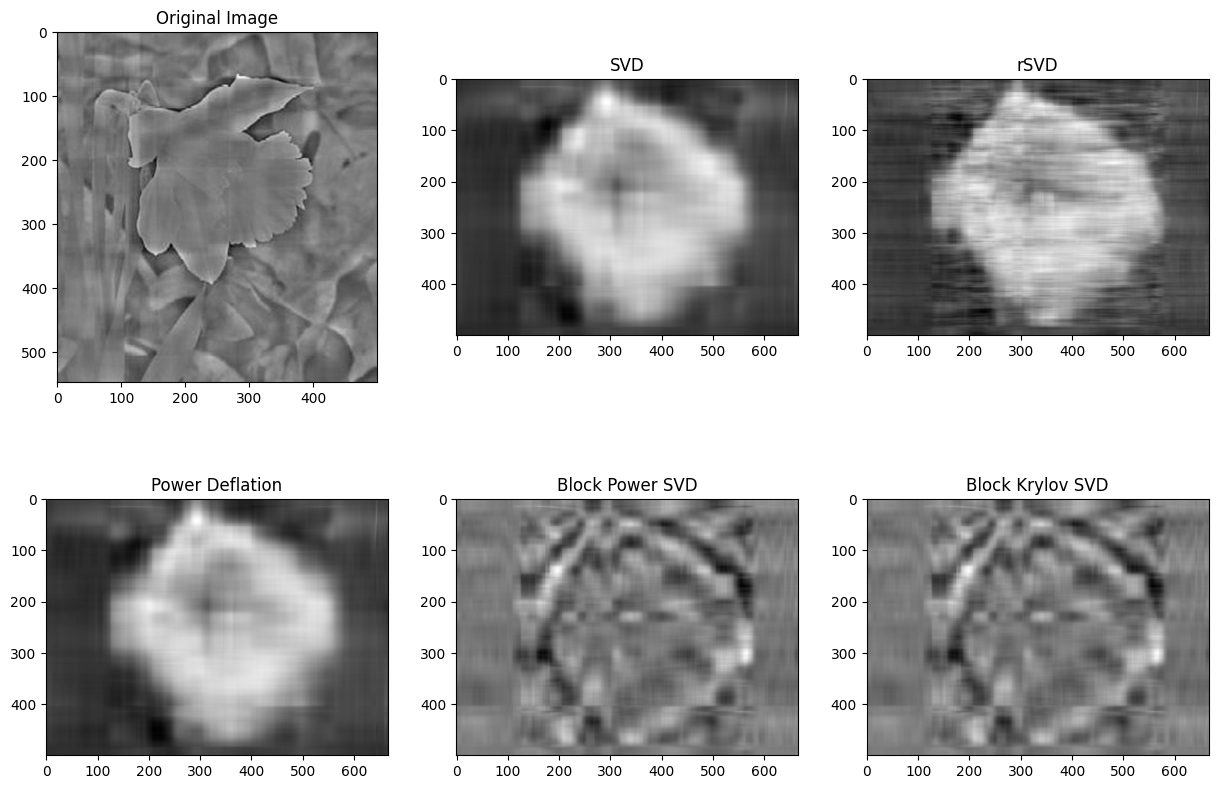

In [ ]:
# Plot the original image and the reconstructed images
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Select an image
image_idx = 0
original_image = images[image_idx]

# Plot the original image
axs[0, 0].imshow(original_image, cmap='gray')
axs[0, 0].set_title('Original Image')

# Plot the reconstructed images
axs[0, 1].imshow(result['SVD'][0], cmap='gray')
axs[0, 1].set_title('SVD')

axs[0, 2].imshow(result['rSVD'][0], cmap='gray')
axs[0, 2].set_title('rSVD')

axs[1, 0].imshow(result['Power Deflation'][0], cmap='gray')
axs[1, 0].set_title('Power Deflation')

axs[1, 1].imshow(result['Block Power SVD'][0], cmap='gray')
axs[1, 1].set_title('Block Power SVD')

axs[1, 2].imshow(result['Block Krylov SVD'][0], cmap='gray')
axs[1, 2].set_title('Block Krylov SVD')

plt.show()

In [ ]:
import numpy as np
import time

# Generate a random matrix of size 1000 by 1200
np.random.seed(0)
A = np.random.rand(10000, 12000)

# Convert the matrix to a numpy array
A = np.array(A)

# Call the compute_all_2 function
start_time = time.time()
k = 10
iters_power = 28
iters_krylov = 21
result = compute_all_2(A, k, iters_power, iters_krylov)
end_time = time.time()

# Print the execution time
print("Execution time: ", end_time - start_time)

# Print the execution times for each method
print("Execution time for SVD: ", result['SVD'][1])
print("Execution time for rSVD: ", result['rSVD'][1])
print("Execution time for Power Deflation: ", result['Power Deflation'][1])
print("Execution time for Block Power SVD: ", result['Block Power SVD'][1])
print("Execution time for Block Krylov SVD: ", result['Block Krylov SVD'][1])

Execution time:  1267.2233157157898
Execution time for SVD:  1169.3946809768677
Execution time for rSVD:  0.8953659534454346
Execution time for Power Deflation:  42.34553122520447
Execution time for Block Power SVD:  24.90149736404419
Execution time for Block Krylov SVD:  25.73673677444458


In [ ]:
import numpy as np

# Block Krylov SVD
def block_Krylov_SVD(A, k, num_iterations=5):
    """ Block Krylov algorithm for approximate SVD

    Parameters:
    A (numpy array): matrix to be approximated
    k (int): desired rank of the approximation
    num_iterations (int, optional): number of iterations (default=5)

    Returns:
    U (numpy array): left singular vectors
    Σ (numpy array): singular values
    V (numpy array): right singular vectors
    """
    m, n = A.shape

    # Initialize random matrices
    U = np.random.randn(m, k)
    V = np.random.randn(n, k)

    # Normalize columns of U and V
    U = U / np.linalg.norm(U, axis=0)
    V = V / np.linalg.norm(V, axis=0)

    # Initialize the block Krylov subspace
    K_U = U
    K_V = V

    for _ in range(num_iterations):
        # Compute A * V
        Y = np.dot(A, K_V)

        # Compute V = A^T * U
        Z = np.dot(A.T, K_U)

        # Append the new block to the Krylov subspace
        K_U = np.hstack((K_U, Y))
        K_V = np.hstack((K_V, Z))

        # Compute the QR decomposition of the Krylov subspace
        Q_U, _ = np.linalg.qr(K_U)
        Q_V, _ = np.linalg.qr(K_V)

        # Update U and V
        U = Q_U[:, :k]
        V = Q_V[:, :k]

        # Update the block Krylov subspace
        K_U = U
        K_V = V

    # Compute Σ = U^T * A * V
    Σ = np.diag(np.dot(U.T, np.dot(A, V)))

    return U, Σ, V

In [ ]:
def block_krylov_SVD(A, k, num_iterations=5):
  """ Block Krylov method for approximate SVD

  Parameters:
  A (numpy array): matrix to be approximated
  k (int): desired rank of the approximation
  num_iterations (int, optional): number of iterations (default=5)

  Returns:
  U (numpy array): left singular vectors
  Σ (numpy array): singular values
  V (numpy array): right singular vectors
  """
  m, n = A.shape

  # Initialize random matrices
  U = np.random.randn(m, k)
  V = np.random.randn(n, k)

  # Normalize columns of U and V
  U = U / np.linalg.norm(U, axis=0)
  V = V / np.linalg.norm(V, axis=0)

  # Initialize Krylov subspace
  K_V = V

  for _ in range(num_iterations):
      # Compute A * K_V
      Y = np.dot(A, K_V)

      # Compute QR decomposition of Y
      Q, R = np.linalg.qr(Y)

      # Update U
      U = Q[:, :k]

      # Compute A^T * U
      Z = np.dot(A.T, U)

      # Update Krylov subspace
      K_V = np.hstack((K_V, Z))

      # Compute QR decomposition of K_V
      Q, R = np.linalg.qr(K_V)

      # Update V
      V = Q[:, :k]

  # Compute Σ = U^T * A * V
  Σ = np.diag(np.dot(U.T, np.dot(A, V)))

  return U, Σ, V